In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

import numpy as np
import os
import pandas as pd
import matplotlib.pyplot as plt

from fastai.imports import *
from fastai.conv_learner import *
from fastai.transforms import *
from fastai.model import *
from fastai.dataset import *
from fastai.sgdr import *
from fastai.plots import *
from torch import nn
import torch.nn.functional as F
from callback import *
from sklearn.metrics import fbeta_score
from sklearn.model_selection import KFold

IMG_PATH = 'train-jpg/'
LBL_PATH = 'train_v2.csv'
n_classes = 17
stats = [[0,0,0], [255.,255.,255.]]

sz = 128
bs=64

val_idxs = get_cv_idxs(len(os.listdir(IMG_PATH)))

def f2(preds, y):
    ret = fbeta_score(y, preds>0.2, beta=2, average='samples')
    return ret

def get_data(sz, val_idxs, bs=bs):
    tfms = tfms_from_stats(stats, sz, aug_tfms=transforms_top_down, max_zoom=1.1)
    data = ImageClassifierData.from_csv('.', 'train-jpg', 'train_v2.csv',bs, tfms, 
                                        val_idxs=val_idxs, 
                                        suffix='.jpg',
                                        test_name='test-jpg')
    return data

def get_model(data):
    custom_head = nn.Sequential(nn.AdaptiveAvgPool2d(1), 
                            Flatten(),
                            nn.Linear(512, n_classes),
                            nn.Sigmoid())

    model = ConvnetBuilder(resnet34, 0,0,0,custom_head=custom_head)

    # learn = ConvLearner.from_model_data(model, get_data(sz), metrics=[f2])
    learn = ConvLearner(data, model, metrics=[f2])
    
    return learn

def predict(learn, name):
    pred,y =learn.TTA(is_test=True)
    pred = np.mean(pred, 0)

#     c = np.array(learn.data.classes)

#     label_text = np.array([' '.join(c[p>thres_opt]) for p in pred])

#     df = pd.DataFrame({'image_name': [f[9:-4] for f in learn.data.test_ds.fnames], 
#                        'tags': label_text})
    df = pd.DataFrame(pred, columns=learn.data.classes)
    df.insert(0, 'id', [f[9:-4] for f in learn.data.test_ds.fnames])

    df.to_csv(name, index=False)
    
def train(learn, k):
    lr=1e-2
    lrs=[lr/10,lr/4,lr]
    learn.fit(lrs, 2, cycle_len = 8, use_clr=(20, 8), 
              callbacks=[SaveBestModel(learn, lrs, 'kfold'+str(k), monitor='loss', patience=16)])
    return learn

### 63 sz

In [15]:
data = get_data(64, val_idxs)
custom_head = nn.Sequential(nn.AdaptiveAvgPool2d(1), 
                            Flatten(),
                            nn.Linear(512, n_classes),
                            nn.Sigmoid())

model = ConvnetBuilder(resnet34, 0,0,0,custom_head=custom_head)

# learn = ConvLearner.from_model_data(model, get_data(sz), metrics=[f2])
learn = ConvLearner(data, model, metrics=[f2])

 89%|████████▊ | 224/253 [00:16<00:01, 19.70it/s, loss=1.18] 

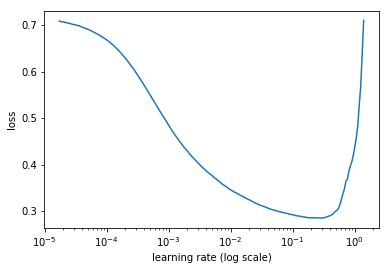

 89%|████████▊ | 224/253 [00:30<00:01, 19.70it/s, loss=1.18]

In [3]:
learn.lr_find()
learn.sched.plot()

In [16]:
learn.fit(0.1, 1, cycle_len = 1)

epoch      trn_loss   val_loss   f2                          
    0      0.581727   0.594398   0.678034  



[array([0.5944]), 0.6780339570460157]

In [17]:
learn.unfreeze()
lr=1e-1
lrs=[lr/10,lr/4,lr]
learn.fit(lrs, 3, cycle_len = 6, use_clr=(20, 8), 
          callbacks=[SaveBestModel(learn, lrs, 'custom_64', monitor='loss', patience=16)])

epoch      trn_loss   val_loss   f2                          
    0      0.127966   0.122502   0.891648  
    1      0.114082   0.13369    0.881164                    
    2      0.115213   0.106777   0.9058                      
  0%|          | 1/506 [00:00<02:47,  3.01it/s, loss=0.115]

KeyboardInterrupt: 

In [ ]:
plot_trainval(learn)

In [6]:
predict(learn, 'custom_64.csv')

### vgg16

In [18]:
data = get_data(128, val_idxs)
custom_head = nn.Sequential(nn.AdaptiveAvgPool2d(1), 
                            Flatten(),
                            nn.Linear(512, n_classes),
                            nn.Sigmoid())

model = ConvnetBuilder(vgg16, 0,0,0,custom_head=custom_head)

# learn = ConvLearner.from_model_data(model, get_data(sz), metrics=[f2])
learn = ConvLearner(data, model, metrics=[f2])


epoch      trn_loss   val_loss   f2                          
    0      0.287651   0.296215   0.688856  



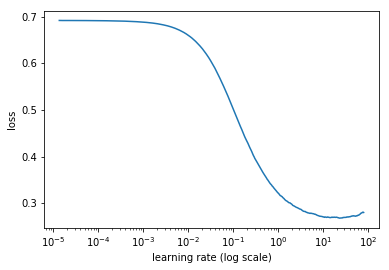

In [12]:
learn.lr_find(end_lr=100)
learn.sched.plot()

In [13]:
learn.fit(1, 2, cycle_len = 1)

epoch      trn_loss   val_loss   f2                          
    0      0.256628   0.256243   0.670821  
    1      0.254424   0.255359   0.673659                    



[array([0.25536]), 0.6736585618187168]

In [14]:
learn.unfreeze()
lr=1
lrs=[lr/20,lr/4,lr]
learn.fit(lrs, 2, cycle_len = 8, use_clr=(20, 8), 
          callbacks=[SaveBestModel(learn, lrs, 'vgg_128', monitor='loss', patience=16)])

epoch      trn_loss   val_loss   f2                          
    0      0.113806   0.128835   0.89036   
    1      0.100544   0.100939   0.911164                     
    2      0.093523   0.092977   0.920789                     
    3      0.090087   0.090827   0.920581                     
    4      0.08653    0.092153   0.920246                     
    5      0.083371   0.089525   0.921923                     
    6      0.079825   0.087748   0.924529                     
    7      0.080306   0.087226   0.924845                     
    8      0.086471   0.093345   0.918732                     
    9      0.085295   0.091414   0.920695                     
    10     0.082545   0.09165    0.920541                     
    11     0.080644   0.090261   0.9214                       
    12     0.073732   0.089512   0.923297                     
    13     0.076822   0.088767   0.92299                      
    14     0.072934   0.088235   0.9252                       
    15     0

[array([0.08876]), 0.9247380899505389]

In [19]:
learn.load('vgg_128')

In [22]:
predict(learn, 'vgg_128.csv')

### vgg19

In [39]:
data = get_data(128, val_idxs, 64)
custom_head = nn.Sequential(nn.AdaptiveAvgPool2d(1), 
                            Flatten(),
                            nn.Linear(512, n_classes),
                            nn.Sigmoid())

model = ConvnetBuilder(vgg19, 0,0,0,custom_head=custom_head)

# learn = ConvLearner.from_model_data(model, get_data(sz), metrics=[f2])
learn = ConvLearner(data, model, metrics=[f2])

Downloading: "https://download.pytorch.org/models/vgg19_bn-c79401a0.pth" to /home/cvpr/.torch/models/vgg19_bn-c79401a0.pth
100%|██████████| 574769405/574769405 [03:10<00:00, 3013430.44it/s] 


epoch      trn_loss   val_loss   f2                          
    0      0.277871   0.291628   0.673659  


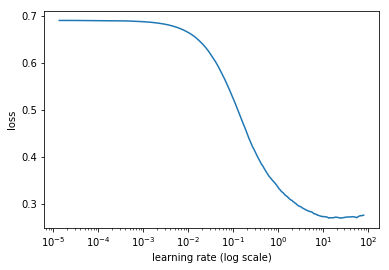

In [40]:
learn.lr_find(end_lr=100)
learn.sched.plot()

In [41]:
learn.fit(1, 1, cycle_len = 1)

epoch      trn_loss   val_loss   f2                          
    0      0.252991   0.255608   0.673659  


[array([0.25561]), 0.6736585618187168]

In [42]:
learn.unfreeze()
lr=1
lrs=[lr/20,lr/4,lr]
learn.fit(lrs, 2, cycle_len = 8, use_clr=(20, 8), 
          callbacks=[SaveBestModel(learn, lrs, 'vgg19_128', monitor='loss', patience=16)])

epoch      trn_loss   val_loss   f2                          
    0      0.113208   0.146132   0.857956  
    1      0.097696   0.099309   0.914047                     
    2      0.093289   0.098105   0.913524                     
    3      0.091426   0.09455    0.919835                     
    4      0.085996   0.093348   0.918158                     
    5      0.083476   0.087183   0.92561                      
    6      0.084464   0.087237   0.924531                     
    7      0.079349   0.086596   0.92556                      
    8      0.085068   0.108435   0.901597                     
    9      0.085602   0.097822   0.914247                     
    10     0.082323   0.089845   0.923155                     
    11     0.080371   0.089417   0.924267                     
    12     0.079212   0.090146   0.921481                     
    13     0.075314   0.08804    0.925043                     
    14     0.071854   0.088726   0.924578                     
    15     0

[array([0.08743]), 0.9255352914891092]

In [43]:
learn.load('vgg19_128')

In [44]:
predict(learn, 'vgg19_128.csv')

### densenet

In [33]:
learn.fit(2e-2, 2, cycle_len = 1)

epoch      trn_loss   val_loss   f2                          
    0      0.263429   0.264011   0.673659  
    1      0.255222   0.256558   0.673659                    


[array([0.25656]), 0.6736585618187168]

In [34]:
learn.unfreeze()
lr=2e-2
lrs=[lr/20,lr/4,lr]
learn.fit(lrs, 2, cycle_len = 8, use_clr=(20, 8), 
          callbacks=[SaveBestModel(learn, lrs, 'dn_128', monitor='loss', patience=16)])

epoch      trn_loss   val_loss   f2                          
    0      0.133236   0.125426   0.890778  
    1      0.111804   0.110089   0.904239                    
    2      0.107349   0.106133   0.905537                    
    3      0.105924   0.103072   0.909996                    
    4      0.103802   0.102779   0.910039                    
    5      0.100937   0.101433   0.910802                     
    6      0.099903   0.099903   0.912456                     
    7      0.101284   0.100125   0.911595                     
    8      0.099854   0.100263   0.912351                     
    9      0.098641   0.09859    0.914614                     
    10     0.09806    0.097798   0.914116                     
    11     0.095849   0.096838   0.913793                     
    12     0.095624   0.096693   0.91451                      
    13     0.095877   0.095741   0.915445                     
    14     0.095677   0.095397   0.916238                     
    15     0.091

[array([0.09514]), 0.9164553042080821]

In [ ]:
predict(learn, 'dn_128.csv')

### fusion

In [45]:
df0 = pd.read_csv('custom_64.csv')
df1 = pd.read_csv('custom_128.csv')
df2 = pd.read_csv('custom_256.csv')
df3 = pd.read_csv('vgg_128.csv')
df4 = pd.read_csv('vgg19_128.csv')

In [46]:
df = df0.drop(['id'],axis=1)
dfs=[df1,df2,df3,df4]
for i in range(len(dfs)):
    df += dfs[i].drop(['id'],axis=1)
df = df / (len(dfs)+1)

In [47]:
c = np.array(learn.data.classes)

label_text = np.array([' '.join(c[p>0.2]) for p in df.values])

df_csv = pd.DataFrame({'image_name': [f[9:-4] for f in learn.data.test_ds.fnames], 
                   'tags': label_text})

In [48]:
df_csv.to_csv('subm.csv', index=False)